# K-Means Clustering on Seattle Weather Data

Using K-Means clustering model on the Seattle Weather data to predict whether it will rain.

In [1]:
# Making necessary imports
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()  # for plot styling
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.manifold import TSNE
from scipy.stats import mode

## Preprocessing Data

In [2]:
# Load the data
df = pd.read_csv('../data/seattle_weather_1948-2017.csv')

In [3]:
# Take a look at the data
df.head()

,DATE,PRCP,TMAX,TMIN,RAIN
0,1948-01-01,0.47,51,42,True
1,1948-01-02,0.59,45,36,True
2,1948-01-03,0.42,45,35,True
3,1948-01-04,0.31,45,34,True
4,1948-01-05,0.17,45,32,True


In [4]:
# Data shape
df.shape

(25551, 5)

In [5]:
# Dataset structure and information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25551 entries, 0 to 25550
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   DATE    25551 non-null  object 
 1   PRCP    25548 non-null  float64
 2   TMAX    25551 non-null  int64  
 3   TMIN    25551 non-null  int64  
 4   RAIN    25548 non-null  object 
dtypes: float64(1), int64(2), object(2)
memory usage: 998.2+ KB


In [6]:
# Check for missing values
df.isna().sum()

DATE    0
PRCP    3
TMAX    0
TMIN    0
RAIN    3
dtype: int64

In [7]:
# Investigate observations with missing values
df[df.isna().any(axis=1)]

,DATE,PRCP,TMAX,TMIN,RAIN
18415,1998-06-02,NaN,72,52,NaN
18416,1998-06-03,NaN,66,51,NaN
21067,2005-09-05,NaN,70,52,NaN


In [8]:
# Remove missing values
df = df.dropna()

In [9]:
# Double check missing values
df.isna().sum()

DATE    0
PRCP    0
TMAX    0
TMIN    0
RAIN    0
dtype: int64

In [10]:
# Take another look of the dataset structure
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25548 entries, 0 to 25550
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   DATE    25548 non-null  object 
 1   PRCP    25548 non-null  float64
 2   TMAX    25548 non-null  int64  
 3   TMIN    25548 non-null  int64  
 4   RAIN    25548 non-null  object 
dtypes: float64(1), int64(2), object(2)
memory usage: 1.2+ MB


In [11]:
# RAIN feature is an object type. Let's investigate its unique values
df['RAIN'].unique()

array([True, False], dtype=object)

In [12]:
# RAIN feature is an object type because it had missing data (i.e. NaN) before removing them
# Since it is clean now, let's change its type to Boolean
df['RAIN'] = df['RAIN'].astype(bool)

In [13]:
# Take a final look at the data information
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25548 entries, 0 to 25550
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   DATE    25548 non-null  object 
 1   PRCP    25548 non-null  float64
 2   TMAX    25548 non-null  int64  
 3   TMIN    25548 non-null  int64  
 4   RAIN    25548 non-null  bool   
dtypes: bool(1), float64(1), int64(2), object(1)
memory usage: 1022.9+ KB


<br>

Since K-Means cannot handle non-numeric values (i.e. DATE feature), we are excluding it from the predictors.

In [14]:
X = df.iloc[:, 1:-1].values.copy()

In [15]:
y = df.iloc[:, -1].values.copy()

## K-Means

In [16]:
# Initiate and train the K-Means model, then predict the response
kmeans = KMeans(n_clusters=2, random_state=0)
clusters = kmeans.fit_predict(X)

In [17]:
# Compute the accuracy
accuracy_score(y, clusters)

0.346563331767653

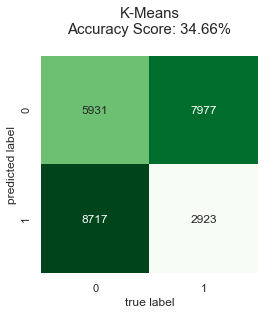

In [18]:
# Plot the confusion matrix
mat = confusion_matrix(y, clusters)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cmap='Greens', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label')
plt.title(f'K-Means\nAccuracy Score: {round(accuracy_score(y, clusters)*100,2)}%\n', size=15);

Because *k*-means knows nothing about the identity of the cluster, the binary (True-False) labels may be permuted. We can fix this by matching each learned cluster label with the true labels found in them:

In [19]:
from scipy.stats import mode

labels = np.zeros_like(clusters)
for i in range(10):
    mask = (clusters == i)
    labels[mask] = mode(y[mask])[0]

In [20]:
# Compute the accuracy
accuracy_score(y, labels)

0.6534366682323469

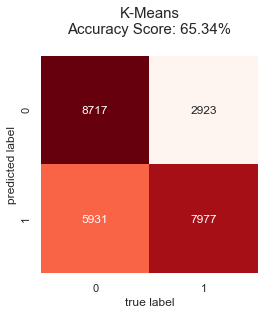

In [21]:
# Plot the confusion matrix
mat = confusion_matrix(y, labels)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cmap='Reds', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label')
plt.title(f'K-Means\nAccuracy Score: {round(accuracy_score(y, labels)*100,2)}%\n', size=15);

### t-distributed Stochastic Neighbor Embedding (t-SNE)

We can use the t-distributed stochastic neighbor embedding (t-SNE) algorithm to pre-process the data before performing *k*-means. t-SNE is a nonlinear embedding algorithm that is particularly adept at preserving points within clusters. Let's see how it does:

In [22]:
# Project the data: this step will take several minutes
tsne = TSNE(n_components=2, init='random', random_state=0)
y_proj = tsne.fit_transform(X)

# Compute the clusters
kmeans = KMeans(n_clusters=2, random_state=0)
clusters = kmeans.fit_predict(y_proj)

# Permute the labels
labels = np.zeros_like(clusters)
for i in range(2):
    mask = (clusters == i)
    labels[mask] = mode(y[mask])[0]

In [23]:
# Compute the accuracy
accuracy_score(y, labels)

0.5785188664474714

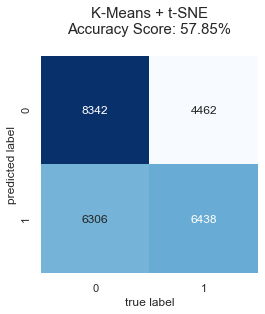

In [24]:
# Plot the confusion matrix
mat = confusion_matrix(y, labels)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label')
plt.title(f'K-Means + t-SNE\nAccuracy Score: {round(accuracy_score(y, labels)*100,2)}%\n', size=15);

### MiniBatchMeans

Because each iteration of *k*-means must access every point in the dataset, the algorithm can be relatively slow as the number of samples grows. You might wonder if this requirement to use all data at each iteration can be relaxed; for example, you might just use a subset of the data to update the cluster centers at each step. This is the idea behind batch-based *k*-means algorithms, one form of which is implemented in `sklearn.cluster.MiniBatchKMeans`:

In [25]:
import warnings; warnings.simplefilter('ignore')  # Fix NumPy issues.
from sklearn.cluster import MiniBatchKMeans

kmeans = MiniBatchKMeans(2, random_state=0).fit(X)
clusters = kmeans.predict(X)

In [26]:
# Compute the accuracy
accuracy_score(y, clusters)

0.3458979176452168

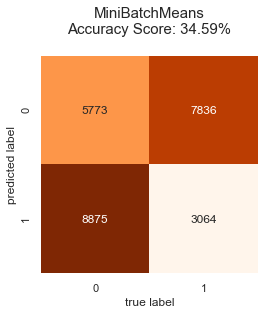

In [27]:
# Plot the confusion matrix
mat = confusion_matrix(y, clusters)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cmap='Oranges', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label')
plt.title(f'MiniBatchMeans\nAccuracy Score: {round(accuracy_score(y, clusters)*100,2)}%\n', size=15);